In [ ]:
!pip install fastapi
!pip install uvicorn
!pip install python-multipart
!pip install pillow
!wget -O dogs_classification.h5 "https://drive.google.com/uc?export=download&id=1XOu3TEG7xlhnnK7wZcTihqKU_pXBMKCj"
!wget -O main.html "https://drive.google.com/uc?export=download&id=1b_sMYDQspCw4U67RNy4S93GX50QYU-Vt"
!wget -O doggy_house.jpg "https://drive.google.com/uc?export=download&id=1WkufVUAYaBJmJepzrTnQzl2GJ2kHZ8KY"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.7 MB/s eta 0:00:00
--2025-01-05 02:56:50--  https://drive.google.com/uc?export=download&id=1XOu3TEG7xlhnnK7wZcTihqKU_pXBMKCj
Resolving drive.google.com (drive.google.com)... 74.125.143.102, 74.125.143.101, 74.125.143.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.143.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1XOu3TEG7xlhnnK7wZcTihqKU_pXBMKCj&export=download [following]
--2025-01-05 02:56:51--  https://drive.usercontent.google.com/download?id=1XOu3TEG7xlhnnK7wZcTihqKU_pXBMKCj&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.145.132, 2a00:1450:4013:c14::84
Connecting to drive.usercontent.google.com (drive.usercontent.g

In [ ]:
%%writefile main.py
import numpy as np
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import HTMLResponse
import uvicorn
from io import BytesIO
from PIL import Image
from typing import Tuple
import tensorflow as tf
import os
import keras

app = FastAPI()

origins = ["*"]

app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

MODEL = tf.keras.models.load_model("./dogs_classification.h5")
CLASS_NAMES = ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Keeshond', 'Kelpie', 'Kerry_blue_terrier', 'Komondor', 'Kuvasz', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Malamute', 'Malinois', 'Maltese_dog', 'Mexican_hairless', 'Miniature_pinscher', 'Miniature_poodle', 'Miniature_schnauzer', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Otterhound', 'Papillon', 'Pekinese', 'Pembroke', 'Pomeranian', 'Pug', 'Redbone', 'Rhodesian_ridgeback', 'Rottweiler', 'Saint_Bernard', 'Saluki', 'Samoyed', 'Schipperke', 'Scotch_terrier', 'Scottish_deerhound', 'Sealyham_terrier', 'Shetland_sheepdog', 'Shih-Tzu', 'Siberian_husky', 'Silky_terrier', 'Soft-coated_wheaten_terrier', 'Staffordshire_bullterrier', 'Standard_poodle', 'Standard_schnauzer', 'Sussex_spaniel', 'Tibetan_mastiff', 'Tibetan_terrier', 'Toy_poodle', 'Toy_terrier', 'Vizsla', 'Walker_hound', 'Weimaraner', 'Welsh_springer_spaniel', 'West_Highland_white_terrier', 'Whippet', 'Wire-haired_fox_terrier', 'Yorkshire_terrier']

@app.get("/ping")
async def ping():
  return {"hello , i am alive"}


def read_file_as_image(data) -> Tuple[np.ndarray, Tuple[int, int]]:
    img = Image.open(BytesIO(data)).convert('RGB')
    img_resized = img.resize((180, 180), resample=Image.BICUBIC)
    image = np.array(img_resized)
    return image, img_resized.size


@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    try:
        IMAGE_SIZE = (224, 224)
        request_object_content = await file.read()
        image = Image.open(BytesIO(request_object_content))
        image.save("./dog.jpg")
        TEST_IMG='./dog.jpg'
        img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
        img_array = keras.utils.img_to_array(img)
        img_array = keras.ops.expand_dims(img_array, 0)
        predictions = MODEL.predict(img_array)
        os.remove("./dog.jpg")
        predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
        confidence = np.max(predictions[0])

        return {
            'class': predicted_class,
            'confidence': float(confidence)
        }
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))


@app.get("/", response_class=HTMLResponse)
async def index():
    with open("main.html", "r") as file:
        return file.read()


Writing main.py


In [ ]:
!nohup uvicorn main:app --host 127.0.0.1 --port 8001 --reload &

nohup: appending output to 'nohup.out'


In [ ]:
import requests
r = requests.get('http://127.0.0.1:8001/ping')
print(r.status_code)
print(r.text)

200
["hello , i am alive"]


In [ ]:
!ssh -o "StrictHostKeyChecking no" -R 80:localhost:8001 serveo.net

Forwarding HTTP traffic from https://308abee25b7d063168ce1a2bec1aa888.serveo.net
HTTP request from 212.74.200.186 to https://308abee25b7d063168ce1a2bec1aa888.serveo.net/
HTTP request from 212.74.200.186 to https://308abee25b7d063168ce1a2bec1aa888.serveo.net/favicon.ico


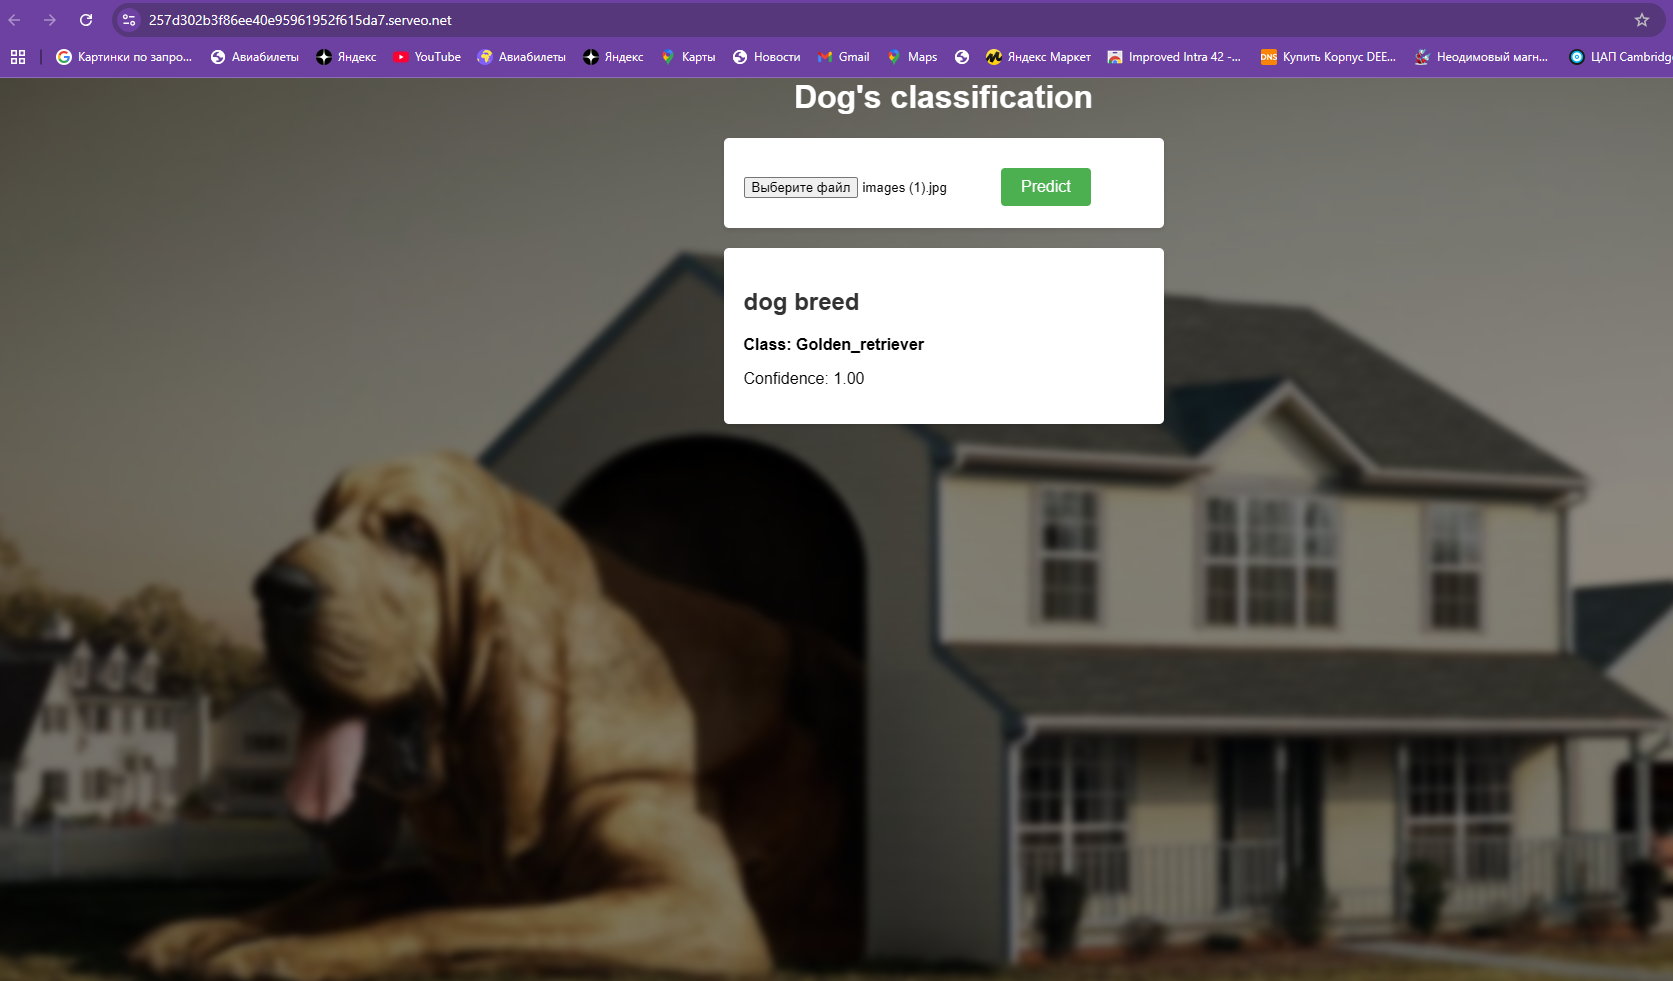